In [1]:
from datasets import load_dataset

/home/rd654/.cache/pypoetry/virtualenvs/pretraining-playground-YJRPv6z4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initial proof of concept setup with 70m model -- loading in updated datsets

In [2]:
activation_dataset = load_dataset("rdiehlmartinez/pythia-training-metrics", "70m__activations", split='default')

/home/rd654/.cache/pypoetry/virtualenvs/pretraining-playground-YJRPv6z4-py3.10/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for rdiehlmartinez/pythia-training-metrics contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rdiehlmartinez/pythia-training-metrics
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
weights_dataset = load_dataset("rdiehlmartinez/pythia-training-metrics", "70m__weights", split='default')

/home/rd654/.cache/pypoetry/virtualenvs/pretraining-playground-YJRPv6z4-py3.10/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for rdiehlmartinez/pythia-training-metrics contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rdiehlmartinez/pythia-training-metrics
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
gradient_dataset = load_dataset("rdiehlmartinez/pythia-training-metrics", "70m__gradients_mini", split='default')

In [10]:
import sys 
sys.path.append('..')
from lib import cka

In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [13]:
checkpoint_steps = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, ]
checkpoint_steps.extend([3000 + (i * 10000) for i in range(0, 15)])

### Computing CKA similarity 

Computation of CKA with model activations 

In [9]:
last_batch = activation_dataset.filter(lambda record: record['checkpoint_step'] == 143_000, num_proc=8)

Iterating over the checkpoint steps and extracting the cka scores for all of the activations (i.e. outputs of the layers) that we track

In [15]:
layer_names = last_batch['layer_name']
cka_scores_per_layer = {layer_name: [] for layer_name in layer_names}

for checkpoint_step in checkpoint_steps:

    checkpoint_activations = activation_dataset.filter(lambda record: record['checkpoint_step'] == checkpoint_step, num_proc=8)
    for layer_activations in checkpoint_activations: 
        layer_name = layer_activations['layer_name']
        layer_activation = np.array(layer_activations['data'])

        last_batch_activation = np.array(last_batch.filter(lambda record: record['layer_name'] == layer_name, num_proc=8)['data'][0])

        cka_score = cka.feature_space_linear_cka(
            layer_activation, 
            last_batch_activation
        )

        cka_scores_per_layer[layer_name].append(cka_score)


In [16]:
# save out the cka scores
with open('cka_scores_per_layer.pkl', 'wb') as f:
    pickle.dump(cka_scores_per_layer, f)

Plotting out the CKA Activation Scores for the 70m model


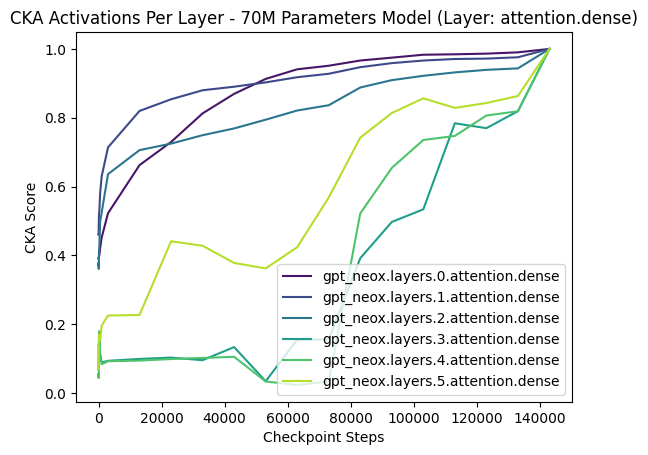

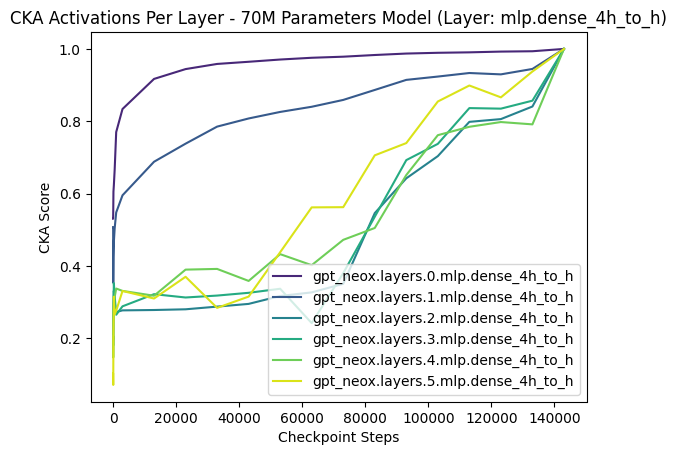

In [37]:
target_layer_suffixes = ["attention.dense", "mlp.dense_4h_to_h"]

for target_layer_suffix in target_layer_suffixes:
    plt.figure()
    plt.title("CKA Activations Per Layer - 70M Parameters Model (Layer: {})".format(target_layer_suffix))

    cmap = plt.get_cmap('viridis')  # Get the colormap

    # Total number of layers to normalize color selection
    total_layers = len(cka_scores_per_layer)

    for i, (layer_name, cka_score) in enumerate(cka_scores_per_layer.items()):

        # NOTE: Filtering out the query_key_value activations which flow into the subsequent dense layer
        if target_layer_suffix not in layer_name:
            continue

        # Normalize color index
        color = cmap(float(i) / total_layers)  # Use the normalized position for color selection
        plt.plot(checkpoint_steps, cka_scores_per_layer[layer_name], label=layer_name, color=color)

    plt.legend()  # Optional: to show layer names
    plt.xlabel('Checkpoint Steps')  # Assuming this is what you're plotting on the x-axis
    plt.ylabel('CKA Score')
    plt.show()

#### Weight magnitude computation

In [41]:
layer_names = set(weights_dataset['layer_name'])
weight_magnitudes_per_layer = {layer_name: [] for layer_name in layer_names}

for checkpoint_step in checkpoint_steps:

    checkpoint_weights = weights_dataset.filter(lambda record: record['checkpoint_step'] == checkpoint_step, num_proc=8)
    for checkpoint_weight in checkpoint_weights: 
        layer_name = checkpoint_weight['layer_name']
        layer_weight = np.array(checkpoint_weight['data'])

        layer_weight_magnitude = np.linalg.norm(layer_weight)

        weight_magnitudes_per_layer[layer_name].append(layer_weight_magnitude)

In [44]:
# save out weight magnitudes
import pickle
with open('weight_magnitudes_per_layer.pkl', 'wb') as f:
    pickle.dump(weight_magnitudes_per_layer, f)

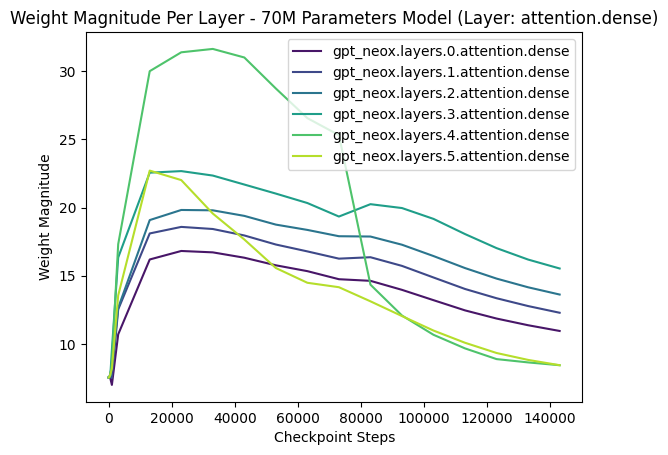

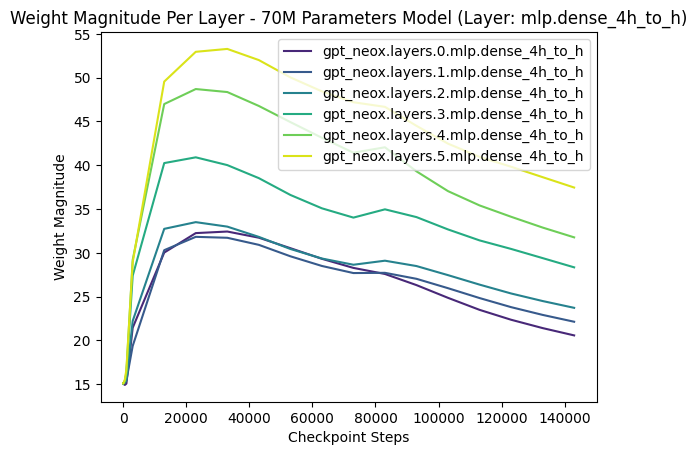

In [45]:
target_layer_suffixes = ["attention.dense", "mlp.dense_4h_to_h"]

for target_layer_suffix in target_layer_suffixes:
    plt.figure()
    plt.title("Weight Magnitude Per Layer - 70M Parameters Model (Layer: {})".format(target_layer_suffix))

    cmap = plt.get_cmap('viridis')  # Get the colormap

    # Total number of layers to normalize color selection
    total_layers = len(weight_magnitudes_per_layer)

    for i, layer_name in enumerate(weight_magnitudes_per_layer.keys()):

        # NOTE: Filtering out the query_key_value activations which flow into the subsequent dense layer
        if target_layer_suffix not in layer_name:
            continue

        # Normalize color index
        color = cmap(float(i) / total_layers)  # Use the normalized position for color selection
        plt.plot(checkpoint_steps, weight_magnitudes_per_layer[layer_name], label=layer_name, color=color)

    plt.legend()  # Optional: to show layer names
    plt.xlabel('Checkpoint Steps')  # Assuming this is what you're plotting on the x-axis
    plt.ylabel('Weight Magnitude')
    plt.show()

#### Gradient Weight magnitude computation

In [43]:
layer_names

{'gpt_neox.layers.0.attention.dense',
 'gpt_neox.layers.0.attention.query_key_value',
 'gpt_neox.layers.0.mlp.dense_4h_to_h',
 'gpt_neox.layers.1.attention.dense',
 'gpt_neox.layers.1.attention.query_key_value',
 'gpt_neox.layers.1.mlp.dense_4h_to_h',
 'gpt_neox.layers.2.attention.dense',
 'gpt_neox.layers.2.attention.query_key_value',
 'gpt_neox.layers.2.mlp.dense_4h_to_h',
 'gpt_neox.layers.3.attention.dense',
 'gpt_neox.layers.3.attention.query_key_value',
 'gpt_neox.layers.3.mlp.dense_4h_to_h',
 'gpt_neox.layers.4.attention.dense',
 'gpt_neox.layers.4.attention.query_key_value',
 'gpt_neox.layers.4.mlp.dense_4h_to_h',
 'gpt_neox.layers.5.attention.dense',
 'gpt_neox.layers.5.attention.query_key_value',
 'gpt_neox.layers.5.mlp.dense_4h_to_h'}

In [33]:
layer_names = set(gradient_dataset['layer_name'])
grad_weight_magnitudes_per_layer = {layer_name: [] for layer_name in layer_names}

for checkpoint_step in checkpoint_steps:
    checkpoint_grads = gradient_dataset.filter(lambda record: record['checkpoint_step'] == checkpoint_step, num_proc=8)

    for layer_name in layer_names:
        layer_checkpoint_grads = checkpoint_grads.filter(lambda record: record['layer_name'] == layer_name, num_proc=8)
        
        avg_layer_grad = None

        for layer_checkpoint_grad in layer_checkpoint_grads:

            _grad_data = np.array(layer_checkpoint_grad['data'])
            _grad_norm = np.linalg.norm(_grad_data)
           
            if avg_layer_grad is None:
                avg_layer_grad = _grad_norm
            else: 
                avg_layer_grad += _grad_norm

        avg_layer_grad /= len(layer_checkpoint_grads)

        grad_weight_magnitudes_per_layer[layer_name].append(avg_layer_grad)

Filter (num_proc=8): 100%|██████████| 36/36 [00:03<00:00, 11.99 examples/s]


In [35]:
# save out grad_weight magnitudes_per_layer_weight
import pickle
with open('grad_weight_magnitudes_per_layer.pkl', 'wb') as f:
    pickle.dump(grad_weight_magnitudes_per_layer, f)

In [47]:
# sort by layer name 
import collections
grad_weight_magnitudes_per_layer = collections.OrderedDict(sorted(grad_weight_magnitudes_per_layer.items()))

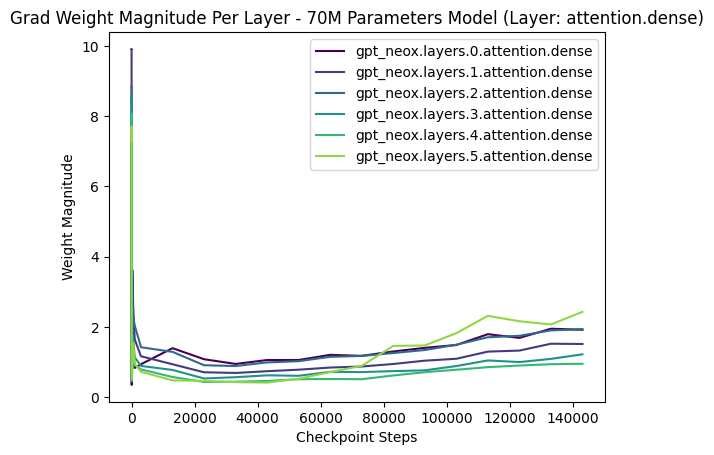

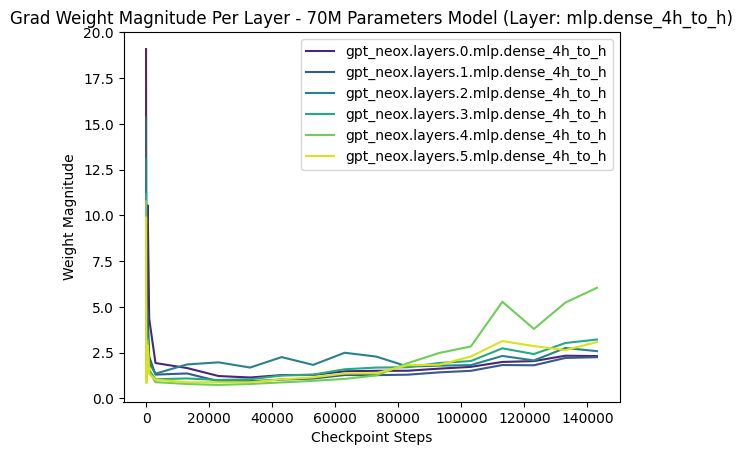

In [48]:
target_layer_suffixes = ["attention.dense", "mlp.dense_4h_to_h"]

for target_layer_suffix in target_layer_suffixes:
    plt.figure()
    plt.title("Grad Weight Magnitude Per Layer - 70M Parameters Model (Layer: {})".format(target_layer_suffix))

    cmap = plt.get_cmap('viridis')  # Get the colormap

    # Total number of layers to normalize color selection
    total_layers = len(grad_weight_magnitudes_per_layer)

    for i, layer_name in enumerate(grad_weight_magnitudes_per_layer.keys()):

        # NOTE: Filtering out the query_key_value activations which flow into the subsequent dense layer
        if target_layer_suffix not in layer_name:
            continue

        # Normalize color index
        color = cmap(float(i) / total_layers)  # Use the normalized position for color selection
        plt.plot(checkpoint_steps, grad_weight_magnitudes_per_layer[layer_name], label=layer_name, color=color)

    plt.legend()  # Optional: to show layer names
    plt.xlabel('Checkpoint Steps')  # Assuming this is what you're plotting on the x-axis
    plt.ylabel('Weight Magnitude')
    plt.show()

#### Gradient cosine conflict computation

In [51]:
layer_names = set(gradient_dataset['layer_name'])
grad_sim_per_layer = {layer_name: [] for layer_name in layer_names}

for checkpoint_step in checkpoint_steps:
    checkpoint_grads = gradient_dataset.filter(lambda record: record['checkpoint_step'] == checkpoint_step, num_proc=8)

    for layer_name in layer_names:
        layer_checkpoint_grads = checkpoint_grads.filter(lambda record: record['layer_name'] == layer_name, num_proc=8)
        
        avg_cosine_sim = None
        prev_grad_data = None

        for layer_checkpoint_grad in layer_checkpoint_grads:

            _grad_data = np.array(layer_checkpoint_grad['data'])
            _grad_data = _grad_data.flatten()

            if prev_grad_data is None:
                prev_grad_data = _grad_data
                continue

            # computing cosine similarity 
            cosine_sim = np.dot(prev_grad_data, _grad_data) / (np.linalg.norm(prev_grad_data) * np.linalg.norm(_grad_data))

            if avg_cosine_sim is None:
                avg_cosine_sim = cosine_sim
            else: 
                avg_cosine_sim += cosine_sim

            prev_grad_data = _grad_data

        avg_cosine_sim /= len(layer_checkpoint_grads)-1

        grad_sim_per_layer[layer_name].append(avg_cosine_sim)

In [55]:
# save out grad_weight magnitudes_per_layer_weight
import pickle
with open('grad_sim_per_layer_weight.pkl', 'wb') as f:
    pickle.dump(grad_sim_per_layer, f)

In [52]:
import collections
grad_sim_per_layer = collections.OrderedDict(sorted(grad_sim_per_layer.items()))

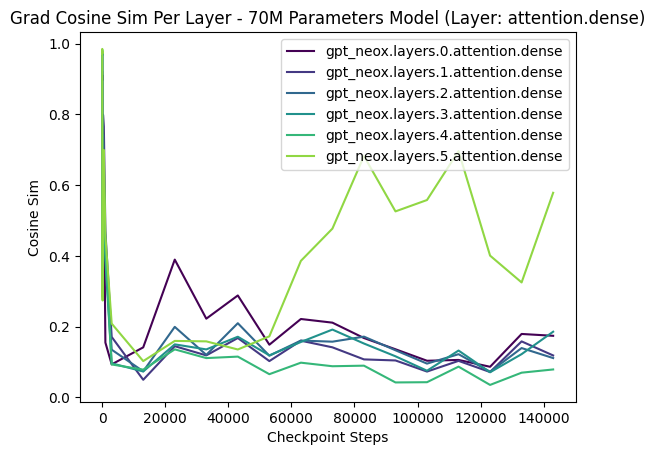

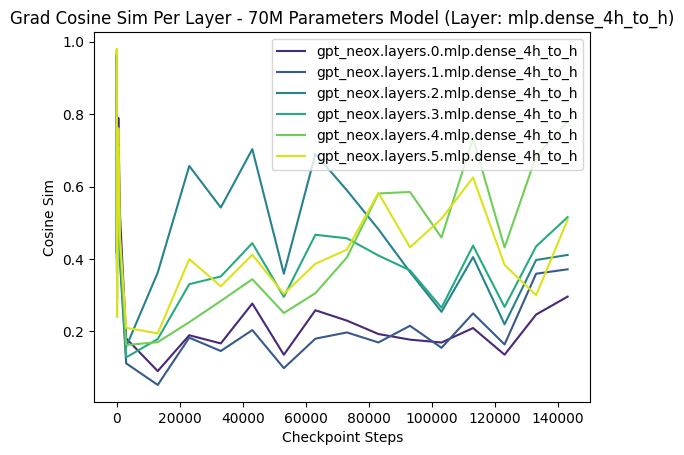

In [54]:
target_layer_suffixes = ["attention.dense", "mlp.dense_4h_to_h"]

for target_layer_suffix in target_layer_suffixes:
    plt.figure()
    plt.title("Grad Cosine Sim Per Layer - 70M Parameters Model (Layer: {})".format(target_layer_suffix))

    cmap = plt.get_cmap('viridis')  # Get the colormap

    # Total number of layers to normalize color selection
    total_layers = len(grad_sim_per_layer)

    for i, layer_name in enumerate(grad_sim_per_layer.keys()):

        # NOTE: Filtering out the query_key_value activations which flow into the subsequent dense layer
        if target_layer_suffix not in layer_name:
            continue

        # Normalize color index
        color = cmap(float(i) / total_layers)  # Use the normalized position for color selection
        plt.plot(checkpoint_steps, grad_sim_per_layer[layer_name], label=layer_name, color=color)

    plt.legend()  # Optional: to show layer names
    plt.xlabel('Checkpoint Steps')  # Assuming this is what you're plotting on the x-axis
    plt.ylabel('Cosine Sim')
    plt.show()